# Intro
In the previous notebook we explored the FD001 dataset and created a baseline model to predict the RUL. The baseline had an RMSE of 31.95. In this notebook we'll re-examine our assumption of RUL and fit an SVR to get a better score.  
Check out my [blog post](https://towardsdatascience.com/the-importance-of-problem-framing-for-supervised-predictive-maintenance-solutions-cc8646826093?source=friends_link&sk=ec51cbfa29f084ed94fe59d0daf51df0) for the full explanation.  
  
<disclaimer: I aim to showcase the effect of different methods and choices made during model development. These effects are often shown using the test set, something which is considered (very) bad practice but helps for educational purposes.>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

## Load data and compute RUL

In [2]:
# define filepath to read data
dir_path = '../data/unzipped/CMAPSSData/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


## Re-examine RUL

Our current assumption of RUL for the train set is that it declines linearly to zero. However, when we inspect the sensor signals they often show a 'bend' in their curve indicating degradation has started. Based on the information given to us we can't really say anything about RUL before this point, as we don't have any information on initial wear and tear of the engines.[Heimes 2008]  
Therefore, we assume RUL to start out constant and only decline linearly after some time. The aim is to get a similar 'bend' in the curve (see image below).   
Starting out with a constant RUL achieves two things:  
1) Initially constant RUL correlates better with the stable mean sensor signal  
2) Lower peak values of RUL results in lower spread of our target variable, making it easier to fit a line

In [4]:
clipped_rul = train.loc[train['unit_nr']==20].copy()
clipped_rul['RUL'].clip(upper=125, inplace=True)

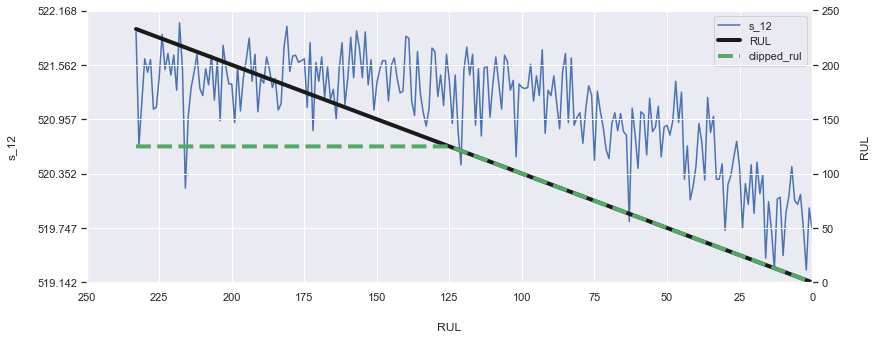

In [5]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot('RUL', 's_12', 'b',
                 data=train.loc[train['unit_nr']==20])
plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('s_12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot('RUL', 'RUL', 'k', linewidth=4,
                   data=train.loc[train['unit_nr']==20])
rul = train.loc[train['unit_nr']==20, 'RUL']
rul_line2 = ax2.plot(rul, rul.where(rul <= 125, 125), '--g', linewidth=4, label='clipped_rul')  # SET LABEL MANUALLY?
ax2.set_ylabel('RUL', labelpad=20)

# code to have equal spacing of y ticks for both axes, so the gridlines allign
# from https://stackoverflow.com/questions/20243683/matplotlib-align-twinx-tick-marks?rq=1
ax2.set_ylim(0, 250)  # set limits of axis you want to display neatly
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))  # choose integer to neatly divide your axis, in our case 6
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))  # apply same spacing to other axis


# code to have a unified legend
# from https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = signal+rul_line+rul_line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)

plt.show()

Let's try this out with our baseline model

In [6]:
# prep data
# drop unwanted columns and split target variable from training set
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [7]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [8]:
## Linear declining RUL
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:44.66819159545453, R2:0.5794486527796716
test set RMSE:31.952633027741815, R2:0.40877368076574083


In [9]:
y_train_clipped = y_train.clip(upper=125)

In [10]:
# I previously used the where method, but .clip seems more intuitive
all(y_train.where(y_train <= 125, 125) == y_train_clipped)

True

In [11]:
## Clipped RUL
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)  

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.491018701515415, R2:0.7340432868050447
test set RMSE:21.900213406890515, R2:0.7222608196546241


As we've updated our assumption of RUL, I feel this should also be reflected in the train evaluation. The True RUL of the test set remains untouched.  
The train RMSE has more than halved. Of course we've set those targets ourselves, but it still shows how much impact the high 'assumed' RUL values had on overall model performance. Much more imporant tough, is the improvement on the test set (almost one third!). Which informs us the updated assumption is beneficial for modeling true RUL

# SVR

In [12]:
# SVM initial regression + clipped RUL
svr = SVR(kernel='linear')
svr.fit(X_train, y_train_clipped)  

# predict and evaluate
y_hat_train = svr.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:29.57783070266026, R2:0.49623314435506494
test set RMSE:29.675150117440094, R2:0.49005151605390174


Results are quite a bit worse, let's try scaling our features to improve model performance

## Scaling

In [13]:
# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
# scaler = StandardScaler()  # for this specific dataset, the type of scaler does not have any effect
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# SVM regression + clipped RUL + scaled
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train_clipped)  

# predict and evaluate
y_hat_train = svr.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE:21.578263975067888, R2:0.7318795396979632
test set RMSE:21.580480163289597, R2:0.730311354095216


Great, the current RMSE is already an improvement over the baseline regression with clipped RUL. Let's see if we can improve it even further with some feature engineering.

## Feature engineering

In [15]:
# Feature engineering
from sklearn.preprocessing import PolynomialFeatures
# 2nd degree polynomialFeatures of [a, b] becomes [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.fit_transform(X_test_scaled)

print(X_train_scaled.shape)
print(X_train_transformed.shape)

(20631, 14)
(20631, 120)


In [16]:
# SVM regression + clipped RUL + engineered features
svr_f = SVR(kernel='linear')
svr_f.fit(X_train_transformed, y_train_clipped)  

# predict and evaluate
y_hat_train = svr_f.predict(X_train_transformed)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr_f.predict(X_test_transformed)
evaluate(y_test, y_hat_test)

train set RMSE:19.716789731130874, R2:0.7761436785704136
test set RMSE:20.585402508370592, R2:0.75460868821153


## Feature selection

In [17]:
# Feature engineering + selection
from sklearn.feature_selection import SelectFromModel
select_features = SelectFromModel(svr_f, threshold='mean', prefit=True)
select_features.get_support()
feature_names = poly.get_feature_names()

print('Original features:\n', X_train.columns)
print('Best features:\n', np.array(feature_names)[select_features.get_support()])
np.array(feature_names)[select_features.get_support()].shape

Original features:
 Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13',
       's_14', 's_15', 's_17', 's_20', 's_21'],
      dtype='object')
Best features:
 ['x0' 'x1' 'x2' 'x3' 'x5' 'x6' 'x7' 'x9' 'x10' 'x11' 'x12' 'x13' 'x2 x5'
 'x2 x8' 'x2 x9' 'x3 x5' 'x3 x8' 'x3 x9' 'x4^2' 'x4 x6' 'x4 x7' 'x4 x8'
 'x5^2' 'x5 x6' 'x5 x7' 'x5 x9' 'x5 x12' 'x5 x13' 'x6^2' 'x6 x8' 'x6 x9'
 'x7 x8' 'x7 x9' 'x8^2' 'x9^2' 'x9 x12' 'x9 x13']


(37,)

In [18]:
# SVM regression + clipped RUL + engineered features + selection
svr = SVR(kernel='linear')
svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped) 

# predict and evaluate
y_hat_train = svr.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

test set RMSE:19.746789101481127, R2:0.775461959316527
test set RMSE:20.55613819605483, R2:0.7553058913450649


Our feature space went from 14 to 120, after feature selection we're back down to 37 features. These features improved out model yet again.

## Simple hyper parameter tuning

In [19]:
epsilon = [0.4, 0.3, 0.2, 0.1, 0.05]

for e in epsilon:
    svr = SVR(kernel='linear', epsilon=e)
    svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

    # predict and evaluate
    y_hat = svr.predict(X_train_transformed[:, select_features.get_support()])
    mse = mean_squared_error(y_train_clipped, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_train_clipped, y_hat)
    print("epsilon:", e, "RMSE:", rmse, "R2:", variance)

epsilon: 0.4 RMSE: 19.74772556660336 R2: 0.7754406619776462
epsilon: 0.3 RMSE: 19.747580761069848 R2: 0.7754439552496148
epsilon: 0.2 RMSE: 19.74660007817171 R2: 0.7754662580123992
epsilon: 0.1 RMSE: 19.746789101481127 R2: 0.775461959316527
epsilon: 0.05 RMSE: 19.746532456984006 R2: 0.7754677958176168


An epsilon of 0.2 seems best for our current model, let's train it again and evaluate on the test set for our final RMSE

## Final model

In [20]:
svr = SVR(kernel='linear', epsilon=0.2)
svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

# predict and evaluate
y_hat_train = svr.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

test set RMSE:19.74660007817171, R2:0.7754662580123992
test set RMSE:20.54412482077374, R2:0.7555918150093489


The final SVR has a test RMSE of 20.54. The combination of updating our assumption of RUL and fitting an SVR with tuned boundaries, feature scaling and polynomial features provides a 35.7 % improvement over our baseline model (RMSE = 31.95).  

Most of this improvement is attributed to changing our assumption of RUL, which shows the importance of framing your data science problem correctly.

In the next analysis we'll delve into timeseries, see you there!

In [21]:
## sources used

# F. O. Heimes, "Recurrent neural networks for remaining useful life estimation," 2008 International Conference on Prognostics and Health Management, Denver, CO, 2008, pp. 1-6, doi: 10.1109/PHM.2008.4711422.

# https://towardsdatascience.com/support-vector-machine-simply-explained-fee28eba5496
# https://www.researchgate.net/publication/320916953_Predicting_Top-of-Atmosphere_Thermal_Radiance_Using_MERRA-2_Atmospheric_Data_with_Deep_Learning
# https://www.researchgate.net/post/When_should_the_support_vector_regression_rather_than_conventional_least_squared_errors_minimization_be_applied
# https://cs.adelaide.edu.au/~chhshen/teaching/ML_SVR.pdf
# https://stats.stackexchange.com/a/287855
# https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2